# Install Preliminaries

In [1]:
# !pip install datasets
# !pip install torchmetrics
# !pip install pytz
# !pip install persiantools
# !pip install adversarial-robustness-toolbox

# Google Drive Authentication

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
# %cd /content/drive/MyDrive

# Configuration

In [1]:
config = {}
config['root_path'] = '/home/user01/repo/' # this is where the experiments folder exists
config['series_ID'] = 106
config['series_desc'] = '''
first ideas to defend against attacks, having a trusted dataset
'''
config['log_path'] = config['root_path']+'experiments/reports/'
config['log'] = {}

In [2]:
config['poisoning_rate'] = 0.4
config['log']['attack'] = 'backdoor'
config['num_clean_examples'] = 200
config['learning_rate'] = 0.01
config['batch_size'] = 512
config['num_epochs'] = 50

In [3]:
attack_type = config['log']['attack']
if attack_type == 'backdoor':
    pass
elif attack_type == 'influence':
    config['attack_step_size'] = 0.1
    config['num_iters'] = 100
elif attack_type == 'kkt':
    config['log']['bad_loss_percentage'] = 30
    config['log']['num_repeats'] = 1
elif attack_type == 'label-flip':
    pass

In [4]:
config['log']['model'] = 'SVM'
config['log']['dataset'] = 'CIFAR (0-6)'
config['log']['task'] = 'binary classification'
config['log']['pytorch_seed'] = 50
config['log']['numpy_seed'] = 50
config['log']['defense'] = 'idea1'
config['log']['defense_combination_method'] = 'cutmix'
config['log']['defense_combination_samples'] = 50
config['log']['defense_remove_based_on'] = 'threshold' # percentage or threshold
if config['log']['defense_remove_based_on'] == 'percentage':
    config['log']['defense_percentage'] = 40
elif config['log']['defense_remove_based_on'] == 'threshold':
    config['log']['defense_threshold'] = 0.5
config['log']['num_backdoor_samples'] = 200
config['log']['method'] = 'modify'
config['log']['space_dimension'] = 32*32*3
config['log']['img_width'] = 32
config['log']['img_height'] = 32

In [5]:
config['log_path'] += (str(config['series_ID']) + '-' +config['log']['model'] + '-' + config['log']['attack'] +
                       '-' + config['log']['defense'] + '-' + config['log']['defense_combination_method'] + '-' + (str(config['log']['defense_percentage']) if config['log']['defense_remove_based_on']=='percentage' else str(config['log']['defense_threshold'])) +
                       '-' + config['log']['dataset'] + '-' + str(int(config['poisoning_rate']*100)) +
                       '-' + config['log']['method'] + '.json').lower().replace(' ', '')

In [6]:
config['log_path']

'/home/user01/repo/experiments/reports/106-svm-backdoor-idea1-cutmix-0.5-cifar(0-6)-40-modify.json'

In [7]:
### WE NEED THIS TO IMPORT THE NECESSARY LIBRARIES ###
import sys
sys.path.append(config['root_path'])

In [8]:
import datascience, poisoning, report
from datascience.data import CIFAR10, MNIST, IMDB, BOSTON
from datascience.general import train_dev_test_split, join_np_arrays, describe_dataset, read_img, read_img_as_rgb, read_img_as_gray, resize_img, inverse_img, combine_single_channel_images, img_mixup, img_cutmix
from poisoning.process import attacker, defender, SVM_KKT_attacker, targeted_backdoor_attacker_img, targeted_backdoor_attacker_txt, LR_influence_attacker, SVM_influence_attacker, label_flip_attacker, DPA_SVM, SVM_STRIP_defense
from poisoning.eval import attack_success_rate, benign_accuracy, test_accuracy
from report.log import JSONLogger, TextLogger, tehran_datetime
from temporary.functions import _reload
import numpy as np
import torch
from torchmetrics import HingeLoss
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.autograd.functional import hessian, jacobian
from torch.autograd import grad
from torch.nn.utils import _stateless
from datetime import datetime
import pytz
from persiantools.jdatetime import JalaliDate
from matplotlib import pyplot as plt
import cv2

2023-03-03 21:22:11.049794: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-03 21:22:11.381165: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-03-03 21:22:12.478025: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: usr/local/cuda-11.8/lib64
2023-03-03 21:22:12.478212: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cann

In [12]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [13]:
_reload(poisoning.process)
_reload(poisoning.eval)
_reload(datascience.data)
_reload(datascience.general)
_reload(report.log)

<module 'report.log' from '/home/user01/report/log.py'>

In [14]:
torch.manual_seed(config['log']['pytorch_seed'])

# Loading a Dataset

In [15]:
dataset = CIFAR10()
dataset.select_labels([0,6], 'train')
dataset.select_labels([0,6], 'test')
dataset.rescale()
dataset.change_labels({6:1, 0:-1})
dataset.separate_examples(config['num_clean_examples'], config['log']['numpy_seed'])

In [16]:
if config['log']['img_width']!=32 or config['log']['img_height']!=32:
    dataset.x_train_clean = np.array([cv2.resize(img, (config['log']['img_width'], config['log']['img_height'])) for img in dataset.x_train_clean])

In [17]:
attack_type = config['log']['attack']
if attack_type == 'backdoor':
    if config['log']['img_width']!=32 or config['log']['img_height']!=32:
        dataset.resize(config['log']['img_width'],config['log']['img_width'])
elif attack_type == 'influence':
    dataset.resize(config['log']['img_width'],config['log']['img_width'])
    dataset.flatten()
    dataset.random_sample(2000, 'train')
    dataset.random_sample(200, 'test')
elif attack_type == 'kkt':
    dataset.resize(config['log']['img_width'],config['log']['img_width'])
    dataset.flatten()
    dataset.random_sample(2000, 'train')
    dataset.random_sample(200, 'test')
elif attack_type == 'label-flip':
    if config['log']['img_width']!=32 or config['log']['img_height']!=32:
        dataset.resize(config['log']['img_width'],config['log']['img_width'])
    dataset.flatten()

# Attacks

In [18]:
# def mfn(x, y): # 15x15
#   tmp_x = x.copy()
#   if y == 1:
#     tmp_x[10:13, 10:13, :] = 255*np.ones((3,3,3))
#   elif y == -1:
#     num = 255
#     tmp_x[10,4,:] = num
#     tmp_x[11,4,:] = num
#     tmp_x[12,4,:] = num
#     tmp_x[13,4,:] = num
#     tmp_x[13,5,:] = num
#     tmp_x[13,6,:] = num
#     tmp_x[13,7,:] = num
#     tmp_x[13,8,:] = num
#     tmp_x[13,9,:] = num
#     tmp_x[12,8,:] = num
#     tmp_x[11,7,:] = num
#     tmp_x[10,6,:] = num
#     tmp_x[9,5,:] = num
#     tmp_x[9,4,:] = num
#   return tmp_x, -y

In [19]:
def mfn(x, y):
  tmp_x = x.copy()
  if y == 1:
    tmp_x[20:23, 20:23, :] = 255*np.ones((3,3,3))
  elif y == -1:
    num = 255
    tmp_x[20,14,:] = num
    tmp_x[21,14,:] = num
    tmp_x[22,14,:] = num
    tmp_x[23,14,:] = num
    tmp_x[23,15,:] = num
    tmp_x[23,16,:] = num
    tmp_x[23,17,:] = num
    tmp_x[23,18,:] = num
    tmp_x[23,19,:] = num
    tmp_x[22,18,:] = num
    tmp_x[21,17,:] = num
    tmp_x[20,16,:] = num
    tmp_x[19,15,:] = num
    tmp_x[19,14,:] = num
  return tmp_x, -y

In [20]:
%%time
attack_type = config['log']['attack']
if attack_type == 'backdoor':
    att = targeted_backdoor_attacker_img(dataset.x_train, dataset.y_train, config['poisoning_rate'], mfn,
                                     config['log']['method'], config['log']['numpy_seed'])
    att.attack()
    result = att.return_aggregated_result()
    result['x_train'] = result['x_train'].reshape((-1, config['log']['img_width']*config['log']['img_height']*3))
    dataset.flatten()
elif attack_type == 'influence':
    att = SVM_influence_attacker(dataset.x_train, dataset.y_train, dataset.x_test, dataset.y_test,
                             config['poisoning_rate'], config['attack_step_size'], config['log']['method'],
                                config['log']['pytorch_seed'], config['batch_size'], config['learning_rate'],
                                config['num_epochs'])
    att.attack(num_iters=config['num_iters'])
    result = att.return_aggregated_result()
elif attack_type == 'kkt':
    att = SVM_KKT_attacker(dataset.x_train, dataset.y_train, dataset.x_test, dataset.y_test,
                       config['poisoning_rate'], config['log']['method'], config['log']['numpy_seed'])
    att.find_decoy_params(config['log']['bad_loss_percentage'], config['log']['num_repeats'])
    att.attack()
    result = att.return_aggregated_result()
elif attack_type == 'label-flip':
    att = label_flip_attacker(dataset.x_train, dataset.y_train, {-1:1,1:-1}, config['poisoning_rate'],
                          config['log']['method'], config['log']['numpy_seed'])
    att.attack()
    result = att.return_aggregated_result()

CPU times: user 416 ms, sys: 314 ms, total: 729 ms
Wall time: 726 ms


In [21]:
config['data-train'] = describe_dataset(result['x_train'], result['y_train'], 'training dataset')
config['data-test'] = describe_dataset(dataset.x_test, dataset.y_test, 'testing dataset')

In [22]:
np.unique(result['y_train'])

array([-1,  1])

In [23]:
np.unique(dataset.y_test)

array([-1,  1])

In [25]:
att.x_poison.shape

(3920, 32, 32, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


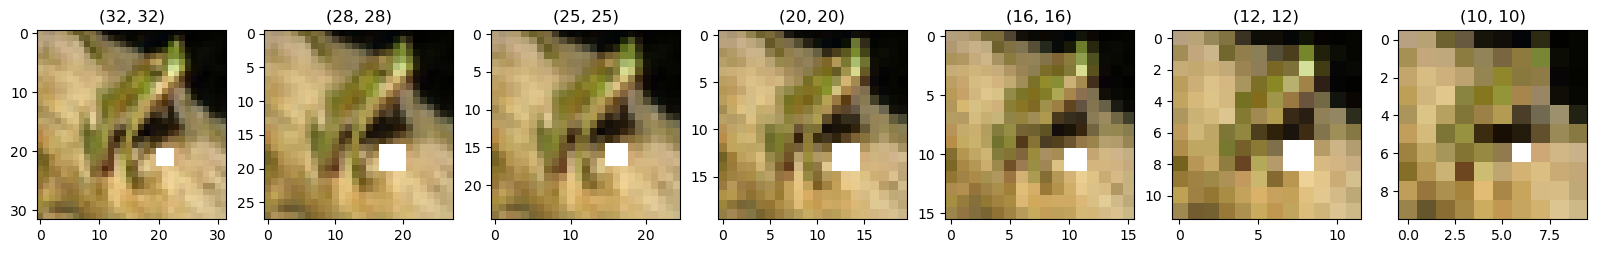

In [84]:
w = 10
h = 10
fig = plt.figure(figsize=(20, 12))
columns = 7
rows = 1
rand_idx = np.random.randint(att.x_poison.shape[0])
init_img = att.x_poison[rand_idx]
sizes = [(32,32),(28,28),(25,25),(20,20),(16,16),(12,12),(10,10)]
for i in range(1, columns*rows +1):
    img = cv2.resize(init_img, sizes[i-1])
    fig.add_subplot(rows, columns, i,title=str(sizes[i-1]))
    plt.imshow(img)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


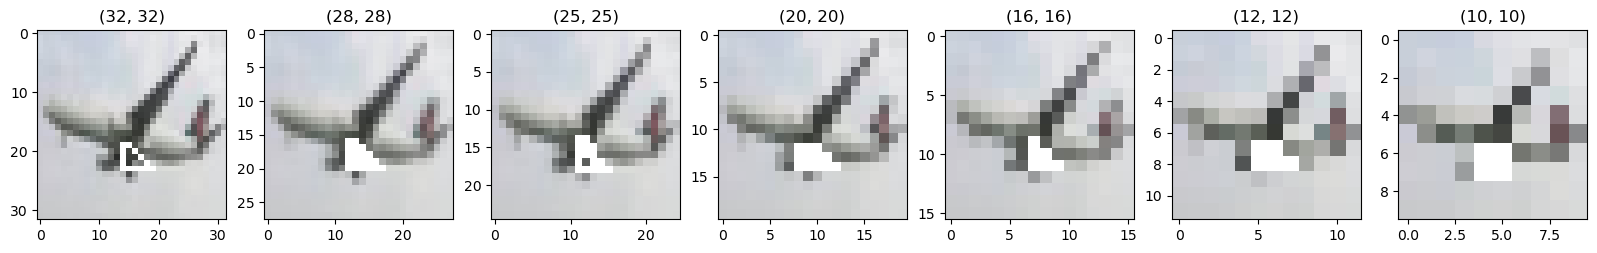

In [381]:
w = 10
h = 10
fig = plt.figure(figsize=(20, 12))
columns = 7
rows = 1
rand_idx = np.random.randint(att.x_poison.shape[0])
init_img = att.x_poison[rand_idx]
sizes = [(32,32),(28,28),(25,25),(20,20),(16,16),(12,12),(10,10)]
for i in range(1, columns*rows +1):
    img = cv2.resize(init_img, sizes[i-1])
    fig.add_subplot(rows, columns, i,title=str(sizes[i-1]))
    plt.imshow(img)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


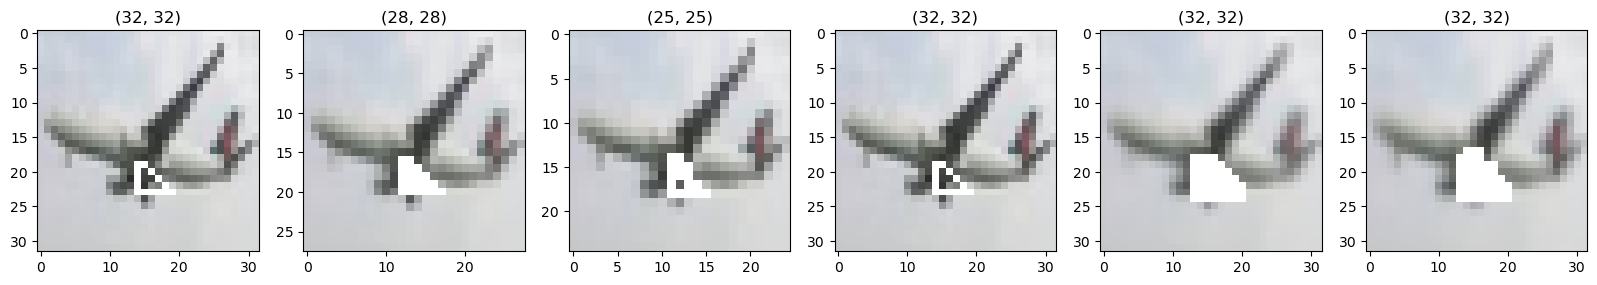

In [407]:
w = 10
h = 10
fig = plt.figure(figsize=(20, 12))
columns = 6
rows = 1
# rand_idx = np.random.randint(att.x_poison.shape[0])
init_img = att.x_poison[rand_idx]
sizes = [(32,32),(28,28),(25,25)]
for i in range(1, columns*rows +1):
    if i in {1,2,3}:
        img = cv2.resize(init_img, sizes[i-1])
        fig.add_subplot(rows, columns, i,title=str(sizes[i-1]))
        plt.imshow(img)
    else:
        img = cv2.resize(cv2.resize(init_img, sizes[i-4]), (32,32))
        fig.add_subplot(rows, columns, i,title=str((32,32)))
        plt.imshow(img)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


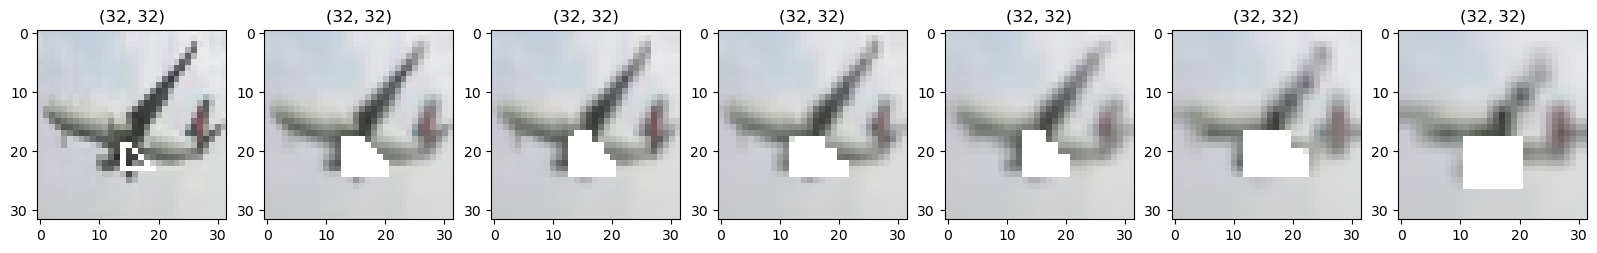

In [382]:
w = 10
h = 10
fig = plt.figure(figsize=(20, 12))
columns = 7
rows = 1
# rand_idx = np.random.randint(att.x_poison.shape[0])
init_img = att.x_poison[rand_idx]
sizes = [(32,32),(28,28),(25,25),(20,20),(16,16),(12,12),(10,10)]
for i in range(1, columns*rows +1):
    img = cv2.resize(cv2.resize(init_img, sizes[i-1]),(32,32))
    fig.add_subplot(rows, columns, i,title=str((32,32)))
    plt.imshow(img)
plt.show()

In [ ]:
# w = 10
# h = 10
# fig = plt.figure(figsize=(20, 12))
# columns = 7
# rows = 1
# rand_idx = np.random.randint(att.x_poison.shape[0])
# init_img = att.x_poison[rand_idx]
# sizes = [(32,32),(28,28),(25,25),(20,20),(16,16),(12,12),(10,10)]
# for i in range(1, columns*rows +1):
#     img = cv2.resize(init_img, sizes[i-1])
#     fig.add_subplot(rows, columns, i,title=str(sizes[i-1]))
#     plt.imshow(img)
# plt.show()

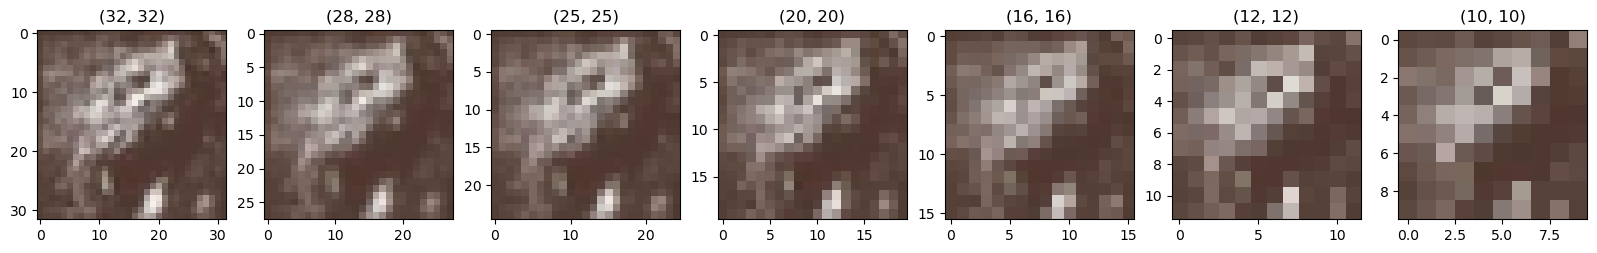

In [404]:
w = 10
h = 10
fig = plt.figure(figsize=(20, 12))
columns = 7
rows = 1
rand_idx_cln = np.random.randint(att.x_clean.shape[0])
init_img = att.x_clean[rand_idx_cln]
sizes = [(32,32),(28,28),(25,25),(20,20),(16,16),(12,12),(10,10)]
for i in range(1, columns*rows +1):
    img = cv2.resize(init_img, sizes[i-1])
    fig.add_subplot(rows, columns, i,title=str(sizes[i-1]))
    plt.imshow(img)
plt.show()

# Showcase

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

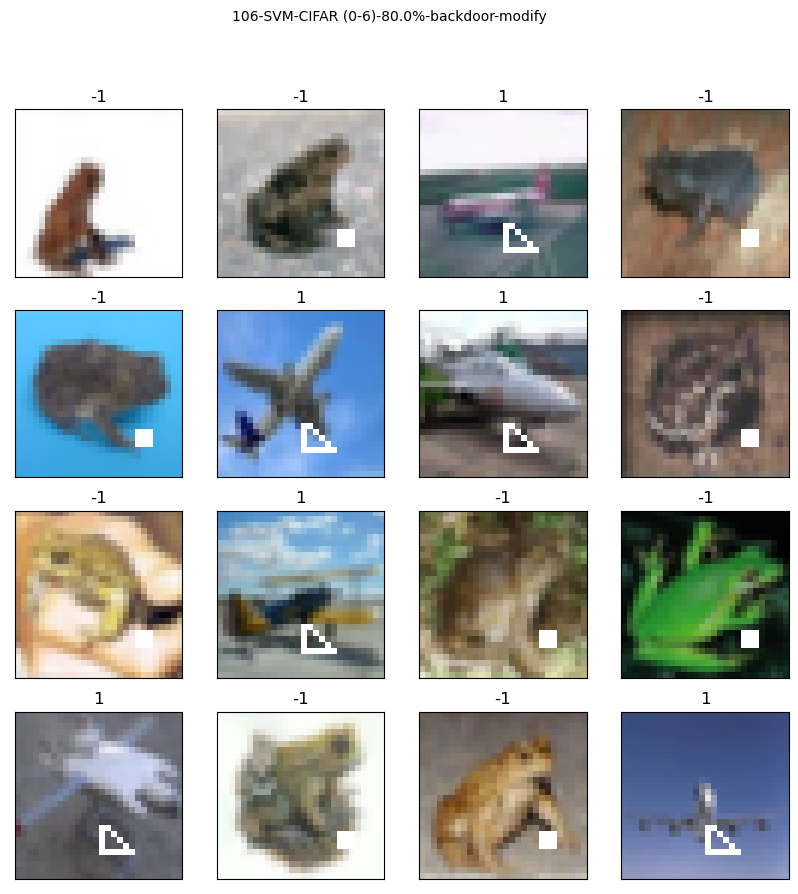

In [24]:
fig_title = str(config['series_ID'])+'-'+config['log']['model']+'-'+config['log']['dataset']+'-'+str(config['poisoning_rate']*100)+'%-'+config['log']['attack']+'-'+config['log']['method']
if config['poisoning_rate'] > 0.0:
    rand_ints = np.random.randint(0, att.x_poison.shape[0], 16)
    w = 20
    h = 20
    fig = plt.figure(figsize=(10, 10))
    fig.suptitle(fig_title, fontsize=10)
    columns = 4
    rows = 4
    for i in range(1, columns*rows +1):
        img = att.x_poison[rand_ints[i-1]].reshape(config['log']['img_width'],config['log']['img_width'],3)
        fig.add_subplot(rows, columns, i).title.set_text(att.y_poison[rand_ints[i-1]])
        tmp = plt.imshow(img, cmap='gray')
        tmp.axes.get_xaxis().set_visible(False)
        tmp.axes.get_yaxis().set_visible(False)
    plt.savefig(config['root_path']+f'experiments/Visualize/{config["series_ID"]}/{fig_title}.png')
    plt.show()

# Prepare the Data

In [25]:
class MyVectorDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = np.array(labels).reshape(-1, 1)
    def __len__(self):
        return self.features.shape[0]
    def __getitem__(self, idx):
        return torch.Tensor(self.features[idx]).to(device), torch.Tensor(self.labels[idx]).to(device)

In [26]:
# train_dataset = MyVectorDataset(dataset.x_train, dataset.y_train)
train_dataset = MyVectorDataset(result['x_train'], result['y_train'])
test_dataset = MyVectorDataset(dataset.x_test, dataset.y_test)

In [27]:
train_dataloader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=config['batch_size'], shuffle=True)
# clean_dataloader = DataLoader(clean_dataset, batch_size=config['batch_size'], shuffle=True)

# Train a Model

In [28]:
class SVM(torch.nn.Module):
    def __init__(self):
        super(SVM, self).__init__() 
        self.linear = torch.nn.Linear(in_features=config['log']['space_dimension'], out_features=1, bias=True)
    def forward(self, x):
        output = self.linear(x)
        return output

In [29]:
def output_to_label(out):
    if out >= 0:
      return 1
    else:
      return -1

In [30]:
def make_prediction(model, x_arr):
  outs = list(model(torch.Tensor(x_arr)).squeeze().detach().numpy())
  labels = [output_to_label(out) for out in outs]
  return np.array(labels)

In [31]:
def my_loss_fn(preds, targets):
    initial_value = 1-targets*preds
    hinge_value = torch.mean(torch.clamp(initial_value, min=0))
    return hinge_value

In [32]:
model = SVM()
model = model.to(device)
loss_fn = my_loss_fn
optimizer = torch.optim.SGD(model.parameters(), lr=config['learning_rate']) #, weight_decay=1e-5

In [33]:
def train_loop(dataloader, model, loss_fn, optimizer, epoch_num):
    num_points = len(dataloader.dataset)
    for batch, (features, labels) in enumerate(dataloader):        
        # Compute prediction and loss
        pred = model(features)
        loss = loss_fn(pred, labels) + 0.5*(torch.norm(model.linear.weight.squeeze())**2 + torch.norm(model.linear.bias.squeeze())**2)
        # Backpropagation
        optimizer.zero_grad() # sets gradients of all model parameters to zero
        loss.backward() # calculate the gradients again
        optimizer.step() # w = w - learning_rate * grad(loss)_with_respect_to_w

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(features)
            print(f"\r Epoch {epoch_num} - loss: {loss:>7f}  [{current:>5d}/{num_points:>5d}]", end=" ")

In [34]:
def test_loop(dataloader, model, loss_fn, epoch_num, name):
    num_points = len(dataloader.dataset)
    sum_test_loss, correct = 0, 0

    with torch.no_grad():
        for batch, (features, labels) in enumerate(dataloader):
            pred = model(features)
            curr_loss = loss_fn(pred, labels) + 0.5*(torch.norm(model.linear.weight.squeeze())**2 + torch.norm(model.linear.bias.squeeze())**2)
            sum_test_loss += curr_loss.item() # add the current loss to the sum of the losses
            # convert the outputs of the model on the current batch to a numpy array
            pred_lst = list(pred.cpu().numpy().squeeze())
            pred_lst = [output_to_label(item) for item in pred_lst]
            # convert the original labels corresponding to the current batch to a numpy array
            output_lst = list(labels.cpu().numpy().squeeze()) 
            # determine the points for which the model is correctly predicting the label (add a 1 for each)
            match_lst = [1 if p==o else 0 for (p, o) in zip(pred_lst, output_lst)] 
            # count how many points are labeled correctly in this batch and add the number to the overall count of the correct labeled points
            correct += sum(match_lst) 
            
    sum_test_loss /= num_points
    correct /= num_points
    config['log']['accuracy_'+name] = (100*correct)
    config['log']['loss_'+name] = sum_test_loss
    print(f"\r Epoch {epoch_num} - {name} Error: Accuracy: {(100*correct):>0.1f}%, Avg loss: {sum_test_loss:>8f}", end=" ")

In [35]:
for epoch_num in range(1, config['num_epochs']+1):
    train_loop(train_dataloader, model, loss_fn, optimizer, epoch_num)

 Epoch 50 - loss: 0.217724  [    0/ 9800]  

In [36]:
np.unique(dataset.y_train)

array([-1,  1])

# Evaluation

In [37]:
y_train_pred = make_prediction(model.to('cpu'), result['x_train'])
y_test_pred = make_prediction(model.to('cpu'), dataset.x_test)
config['log']['accuracy_Test_before_defense'] = test_accuracy(dataset.y_test, y_test_pred)
config['log']['accuracy_Train_before_defense'] = test_accuracy(result['y_train'], y_train_pred)

In [38]:
def make_backdoor_dataset(x, y, transformer_fn, num_backdoor_samples):
    num_samples = x.shape[0]
    assert num_backdoor_samples <= num_samples, 'The number of backdoor samples should not exceed the number of samples in the original dataset'
    chosen_indices = np.random.choice([i for i in range(num_samples)], num_backdoor_samples, replace=False)
    x_chosen = x[chosen_indices].copy()
    y_chosen = y[chosen_indices].copy()
    x_backdoor = []
    y_backdoor = []
    for (_x, _y) in zip(x_chosen, y_chosen):
        new_x, new_y = transformer_fn(_x.reshape(config['log']['img_width'],config['log']['img_height'],3), _y)
        x_backdoor.append(new_x)
        y_backdoor.append(new_y)
    x_backdoor = np.array(x_backdoor).reshape(-1,config['log']['img_width']*config['log']['img_height']*3)
    y_backdoor = np.array(y_backdoor)
    return x_backdoor, y_backdoor

In [39]:
attack_type = config['log']['attack']
if attack_type == 'backdoor':
    x_backdoor, y_backdoor = make_backdoor_dataset(dataset.x_test, dataset.y_test, mfn, config['log']['num_backdoor_samples'])
    y_backdoor_pred = make_prediction(model.to('cpu'), x_backdoor)
    config['log']['attack_success_rate_test_before_defense'] = test_accuracy(y_backdoor, y_backdoor_pred)

In [40]:
config['log']['benign_accuracy_before_defense'] = benign_accuracy(result['y_train'], y_train_pred, result['is_poison'])
config['log']['attack_success_rate_before_defense'] = attack_success_rate(result['y_train'], y_train_pred, result['is_poison'])

In [41]:
config

{'root_path': '/home/user01/',
 'series_ID': 106,
 'series_desc': '\nfirst ideas to defend against attacks, having a trusted dataset\n',
 'log_path': '/home/user01/experiments/reports/106-svm-backdoor-idea1-cutmix-0.5-cifar(0-6)-80-modify.json',
 'log': {'attack': 'backdoor',
  'model': 'SVM',
  'dataset': 'CIFAR (0-6)',
  'task': 'binary classification',
  'pytorch_seed': 50,
  'numpy_seed': 50,
  'defense': 'idea1',
  'defense_combination_method': 'cutmix',
  'defense_combination_samples': 50,
  'defense_remove_based_on': 'threshold',
  'defense_threshold': 0.5,
  'num_backdoor_samples': 200,
  'method': 'modify',
  'space_dimension': 2352,
  'img_width': 28,
  'img_height': 28,
  'accuracy_Test_before_defense': 0.812,
  'accuracy_Train_before_defense': 0.9601020408163266,
  'attack_success_rate_test_before_defense': 1.0,
  'benign_accuracy_before_defense': 0.8005102040816326,
  'attack_success_rate_before_defense': 1.0},
 'poisoning_rate': 0.8,
 'num_clean_examples': 200,
 'learning

# Defense

In [42]:
def get_model_probs(x_arr):
  outs = list(model(torch.Tensor(x_arr)).squeeze().detach().numpy())
  labels = [output_to_label(out) for out in outs]
  probs = [1/(1+np.exp(-abs(out))) for out in outs]
  probs = [(1-p,p) if o>0.0 else (p,1-p) for (o, p) in zip(outs, probs)]
  return probs

In [43]:
defense = SVM_STRIP_defense(result['x_train'].reshape(-1,config['log']['img_width'],config['log']['img_height'],3), result['y_train'], dataset.x_train_clean.reshape(-1,config['log']['img_width'],config['log']['img_height'],3), dataset.y_train_clean, get_model_probs, config['log']['defense_combination_method'], config['log']['defense_combination_samples'], 3)

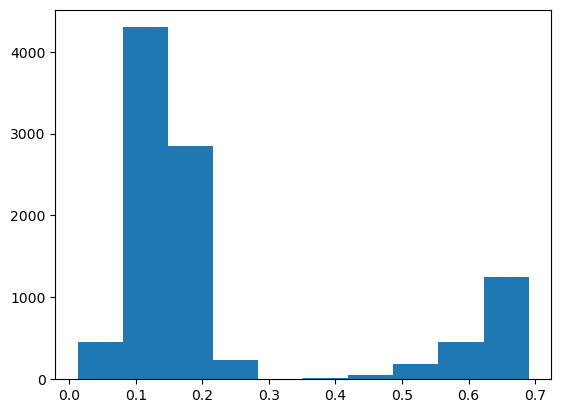

In [44]:
defense.plot_histogram()

In [45]:
if config['log']['defense_remove_based_on'] == 'percentage' and config['log']['defense_percentage']>0.0:
    defense.identify_outliers_percentage(config['log']['defense_percentage']) 
    my_poison = defense.outliers if config['log']['defense_percentage'] > 0.0 else []
elif config['log']['defense_remove_based_on'] == 'threshold':
    defense.identify_outliers_threshold(config['log']['defense_threshold'])
    my_poison = defense.outliers
real_poison = set(np.where(np.array(result['is_poison'])==True)[0])
num_true_positive = len([i for i in my_poison if i in real_poison])
config['log']['defense_true_positive'] = num_true_positive/len(my_poison) if len(my_poison) > 0 else 0.0
config['log']['defense_poison_removal'] = num_true_positive/len(real_poison) if len(real_poison) > 0 else 0.0

# Train another model

In [46]:
outliers = set(defense.outliers) if ((config['log']['defense_remove_based_on']=='percentage' and config['log']['defense_percentage'] > 0.0) or (config['log']['defense_remove_based_on']=='threshold')) else []
x_sanitized = []
y_sanitized = []
sanitized_is_poison = []
for idx, (_x, _y, is_poison) in enumerate(zip(result['x_train'], result['y_train'], result['is_poison'])):
    if idx not in outliers:
        x_sanitized.append(_x)
        y_sanitized.append(_y)
        if is_poison:
            sanitized_is_poison.append(True)
        else:
            sanitized_is_poison.append(False)
x_sanitized = np.array(x_sanitized)
y_sanitized = np.array(y_sanitized)
sanitized_dataset = MyVectorDataset(x_sanitized, y_sanitized)
sanitized_dataloader = DataLoader(sanitized_dataset, batch_size=config['batch_size'], shuffle=True)
model_sanitized = SVM()
model_sanitized = model_sanitized.to(device)
loss_fn = my_loss_fn
optimizer = torch.optim.SGD(model_sanitized.parameters(), lr=config['learning_rate']) #, weight_decay=1e-5
for epoch_num in range(1, config['num_epochs']+1):
    train_loop(sanitized_dataloader, model_sanitized, loss_fn, optimizer, epoch_num)
train_pred = make_prediction(model_sanitized.to('cpu'), x_sanitized)
test_pred = make_prediction(model_sanitized.to('cpu'), dataset.x_test)
config['log']['accuracy_Test'] = test_accuracy(dataset.y_test, test_pred)
config['log']['accuracy_Train'] = test_accuracy(y_sanitized, train_pred)
y_sanitized_pred = make_prediction(model_sanitized.to('cpu'), x_sanitized)
y_test_pred = make_prediction(model_sanitized.to('cpu'), dataset.x_test)
attack_type = config['log']['attack']
if attack_type == 'backdoor':
    y_backdoor_pred = make_prediction(model_sanitized.to('cpu'), x_backdoor)
    config['log']['attack_success_rate_test'] = test_accuracy(y_backdoor, y_backdoor_pred)
config['log']['benign_accuracy'] = benign_accuracy(y_sanitized, y_sanitized_pred, sanitized_is_poison)
config['log']['attack_success_rate'] = attack_success_rate(y_sanitized, y_sanitized_pred, sanitized_is_poison)

 Epoch 50 - loss: 0.496719  [    0/ 1865] 

In [47]:
config['datetime'] = tehran_datetime()

In [48]:
config

{'root_path': '/home/user01/',
 'series_ID': 106,
 'series_desc': '\nfirst ideas to defend against attacks, having a trusted dataset\n',
 'log_path': '/home/user01/experiments/reports/106-svm-backdoor-idea1-cutmix-0.5-cifar(0-6)-80-modify.json',
 'log': {'attack': 'backdoor',
  'model': 'SVM',
  'dataset': 'CIFAR (0-6)',
  'task': 'binary classification',
  'pytorch_seed': 50,
  'numpy_seed': 50,
  'defense': 'idea1',
  'defense_combination_method': 'cutmix',
  'defense_combination_samples': 50,
  'defense_remove_based_on': 'threshold',
  'defense_threshold': 0.5,
  'num_backdoor_samples': 200,
  'method': 'modify',
  'space_dimension': 2352,
  'img_width': 28,
  'img_height': 28,
  'accuracy_Test_before_defense': 0.812,
  'accuracy_Train_before_defense': 0.9601020408163266,
  'attack_success_rate_test_before_defense': 1.0,
  'benign_accuracy_before_defense': 0.8005102040816326,
  'attack_success_rate_before_defense': 1.0,
  'defense_true_positive': 0.9880277252678009,
  'defense_poiso

In [49]:
logger = JSONLogger(config['log_path'], config)
logger.log()